In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import a Gaussian process regressor and define your custom kernel.
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.ensemble import RandomForestRegressor

# Import PySR for symbolic regression.
from pysr import PySRRegressor
import os
os.environ["JULIA_NUM_THREADS"] = "8"  # Use 8 threads (adjust as needed)

In [2]:
# =========================
# 1. Load and Prepare Data
# =========================
data = pd.read_csv("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/real_estate/real_estate_valuation_cleaned.csv")
# Use "X2 distance MRT station" and "X3 number convenience stores" as predictors,
# and "X6 price" as the target.
X = data[["X2 distance MRT station", "X3 number convenience stores"]].values
y = data["X6 price"].values

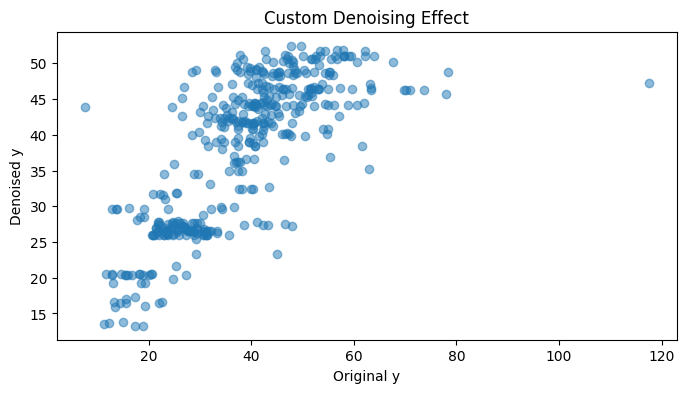

In [198]:
# ========================================
# 2. Custom Denoising via Gaussian Process
# ========================================
# Define a custom kernel. For less smoothing, use a smaller RBF length scale.
custom_kernel = ConstantKernel(1.0) * RBF() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=custom_kernel, n_restarts_optimizer=10)
gp.fit(X, y)
# Generate denoised targets using your custom GP.
y_denoised_custom = gp.predict(X)

# Optionally, you can visualize the effect of denoising:
plt.figure(figsize=(8,4))
plt.scatter(y, y_denoised_custom, alpha=0.5)
plt.xlabel("Original y")
plt.ylabel("Denoised y")
plt.title("Custom Denoising Effect")
plt.show()

26.3**2 * RBF(length_scale=30) + WhiteKernel(noise_level=62.8)


c:\Users\svenl\miniconda3\envs\hyperRealDataDescriber\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 30.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


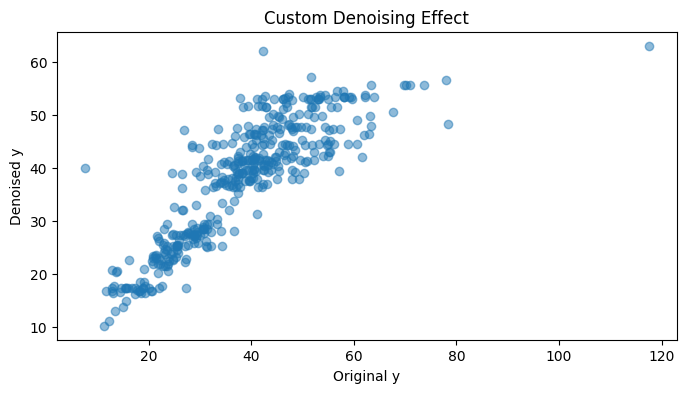

In [245]:
# Fix the hyperparameters by setting bounds to "fixed"
# kernel = (ConstantKernel(1.0, constant_value_bounds="fixed") *
#           RBF(length_scale=0.1, length_scale_bounds="fixed") +
#           WhiteKernel(noise_level=1.0, noise_level_bounds="fixed"))

# # Disable optimization by setting optimizer=None
# gp_fixed = GaussianProcessRegressor(kernel=kernel, optimizer=None)
# gp_fixed.fit(X, y)
kernel = (ConstantKernel(1.0, (1e-3, 1e3)) *
          RBF(length_scale=0.1, length_scale_bounds=(1e-3, 30)) +
          WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e3)))

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=5)
gp.fit(X, y)
print(gp.kernel_)
y_denoised_fixed = gp.predict(X)

# Optionally, you can visualize the effect of denoising:
plt.figure(figsize=(8,4))
plt.scatter(y, y_denoised_fixed, alpha=0.5)
plt.xlabel("Original y")
plt.ylabel("Denoised y")
plt.title("Custom Denoising Effect")
plt.show()

In [38]:
# ====================================================
# 3. Run PySR on the Custom-Denoised Targets (No Built-in Denoising)
# ====================================================
# Here, we disable PySR's built-in denoising (denoise=False)
# because we've already processed the targets.
model = PySRRegressor(niterations=1000, denoise=False, progress=True)
model.fit(X, y_denoised_fixed)
print("Discovered symbolic regression model:")
print(model)

c:\Users\svenl\miniconda3\envs\hyperRealDataDescriber\Lib\site-packages\pysr\sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.960e+04
Progress: 432 / 31000 total iterations (1.394%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.312e+02  1.594e+01  y = 37.682
3           9.377e+01  1.679e-01  y = x₁ + 33.584
5           4.424e+01  3.756e-01  y = (x₀ * -0.0073978) + 45.698
7           3.673e+01  9.302e-02  y = (x₁ + 40.079) - (x₀ * 0.0059909)
9           3.655e+01  2.468e-03  y = 39.061 - ((x₁ / -0.84643) + (x₀ * 0.005736))
11          3.347e+01  4.407e-02  y = ((x₁ - (x₀ * 0.0053083)) - (-472.64 / x₀)) + 37.902
15          3.346e+01  4.408e-05  y = ((20.03 / (x₀ / 23.843)) + 38.072) - ((x₁ * -0.96585) ...
                                      - (x₀ * -0.0053491))
17          3.334e+01  1.775e-03  y = ((x₁ + 32.889) * (x₀ * (-150.07 - (x₀ * -0.021049)))) ...
        

[ Info: Final population:
[ Info: Results saved to:


Discovered symbolic regression model:
PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          37.681713   
	1         0.167931                                      x1 + 33.58402   
	2   >>>>  0.648646                       96205.266 / (x0 + 1814.2719)   
	3         0.029441            (48336.33 / (x0 + 1047.7969)) + 9.49781   
	4         0.001786   (48548.895 / ((x0 - x1) + 1058.7047)) + 9.478296   
	5         0.020385  96205.266 / (((-2053.9905 / (297.9399 - x0)) +...   
	6         0.004696  96348.68 / (x0 + (((x0 * -5.1377697) / (296.50...   
	7         0.028047  (-2908.3652 / ((x0 + ((-1665.4081 / (297.56116...   
	8         0.015377  (-2908.3696 / ((((x0 + (-1665.3967 / (298.0135...   
	9         0.013287  ((x1 * 0.49227062) - -9.57434) + (-2908.3555 /...   
	10        0.000013  ((x1 * 0.49228093) - -9.574344) + (-2908.3555 ...   
	11        0.003325  (-3172.2585 / (((x0 + (-

In [338]:
# ==========================================
# 4. Candidate Selection and Conversion (Example)
# ==========================================
# Let's say you select the first candidate function.
selected_eq_str = "(-3172.2585 / (((x0 + (-2053.9707 / ((x1 + (290.34222 - x0)) / 0.66621494))) + 1167.8259) / -14.898881)) + ((x1 * 0.5063245) + 9.724749)"
print("Selected candidate equation:", selected_eq_str)

# Convert the candidate string to a sympy expression.
from sympy import sympify, symbols, lambdify
f_sympy = sympify(selected_eq_str)
# Identify free symbols in the expression (e.g. "x0", "x1")
free_syms = sorted(f_sympy.free_symbols, key=lambda s: s.name)
print("Free symbols:", free_syms)
# Create a lambda function for numerical evaluation.
f_callable = lambdify(free_syms, f_sympy, 'numpy')

def candidate_function(X):
    # Assumes ordering: first free symbol -> first column, etc.
    if len(free_syms) == 1:
        return f_callable(X[:, 0])
    elif len(free_syms) == 2:
        return f_callable(X[:, 0], X[:, 1])
    else:
        args = [X[:, i] for i in range(len(free_syms))]
        return f_callable(*args)

Selected candidate equation: (-3172.2585 / (((x0 + (-2053.9707 / ((x1 + (290.34222 - x0)) / 0.66621494))) + 1167.8259) / -14.898881)) + ((x1 * 0.5063245) + 9.724749)
Free symbols: [x0, x1]


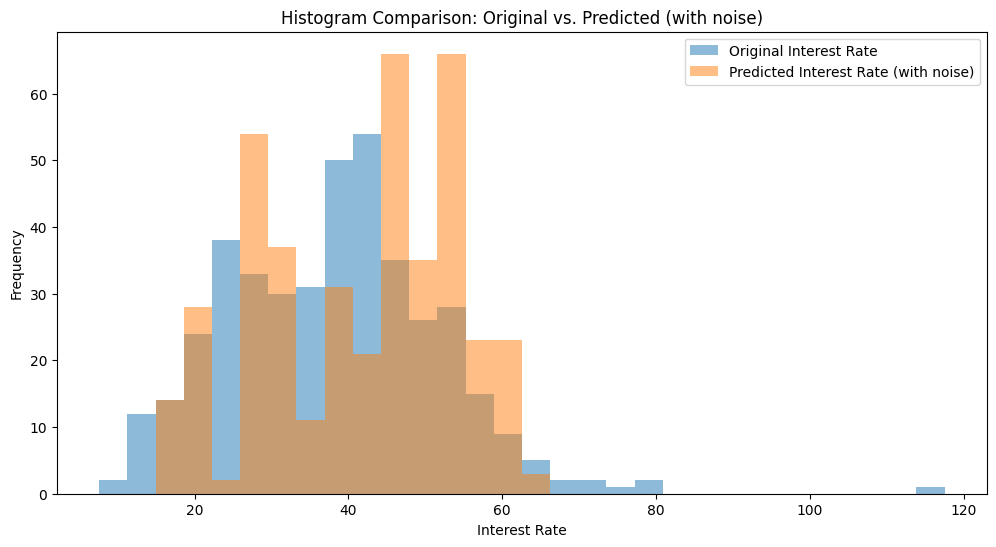

In [331]:
y_denoised = candidate_function(X)
bins = np.histogram_bin_edges(np.concatenate([y, y_denoised]), bins=30)
plt.figure(figsize=(12, 6))
plt.hist(y, bins=bins, alpha=0.5, label="Original Interest Rate")
plt.hist(y_denoised, bins=bins, alpha=0.5, label="Predicted Interest Rate (with noise)")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: Original vs. Predicted (with noise)")
plt.legend()
plt.show()

Estimated noise standard deviation: 9.329368079742364
Best amplification factor: 1.0526315789473684
Corresponding histogram MSE: 8.011405937277734e-06


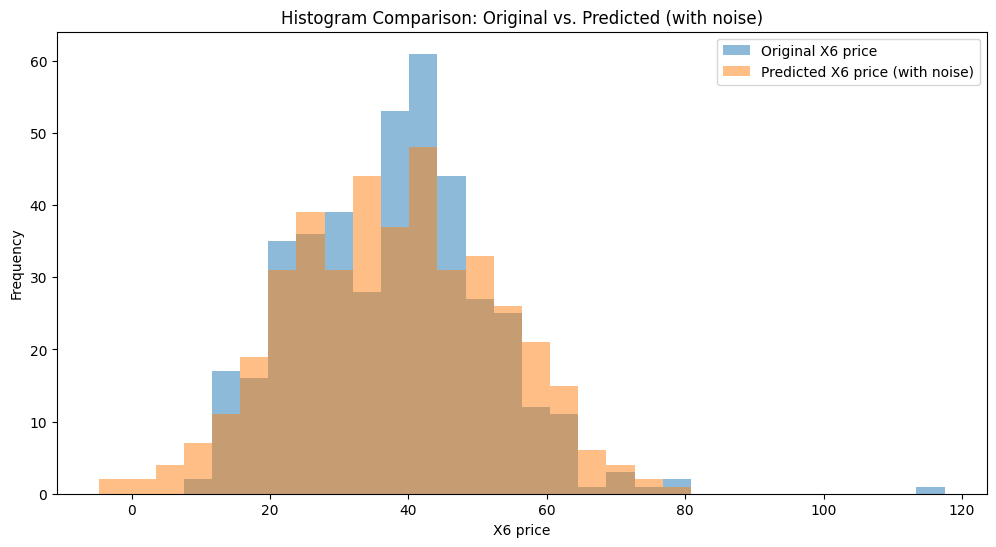

In [302]:
# ==========================================
# 5. Reintroduce Noise to Match Original Distribution
# ==========================================
# Estimate the noise level using residuals between original and denoised targets.
# Get the candidate (denoised) prediction:
y_denoised = candidate_function(X)
residuals = y - y_denoised  # empirical residuals
noise_std = np.std(residuals)
print("Estimated noise standard deviation:", noise_std)

# Set up a function to perform bootstrapping with an amplification factor,
# compute the re-noised predictions, then return the error between histograms.
def compute_histogram_mse(amplification_factor, noise_std, bins=30):
    # Fix the seed for reproducibility.
    # np.random.seed(42)
    # Sample residuals with replacement using bootstrapping
    std_noise = np.random.normal(0, noise_std, size=y_denoised.shape)
    # Reintroduce noise with amplification
    y_pred = y_denoised_fixed + amplification_factor * std_noise
    
    # Compute histograms for both original and predicted data.
    # We'll use density=True so that differences in total count are normalized out.
    hist_original, bin_edges = np.histogram(y, bins=bins, density=True)
    hist_pred, _ = np.histogram(y_pred, bins=bin_edges, density=True)
    
    # Compute Mean Squared Error between the two histograms.
    mse = np.mean((hist_original - hist_pred) ** 2)
    return mse, bin_edges, hist_original, hist_pred, y_pred

# Perform a simple grid search over a range of amplification factors.
amplification_factors = np.linspace(0.5, 2.0, 20)
errors = []

for factor in amplification_factors:
    mse, _, _, _, _ = compute_histogram_mse(factor, noise_std, bins=30)
    errors.append(mse)

# Find the amplification factor that yields the smallest histogram error.
best_idx = np.argmin(errors)
best_amp = amplification_factors[best_idx]
print("Best amplification factor:", best_amp)
print("Corresponding histogram MSE:", errors[best_idx])

# Use the best amplification factor to generate the final predictions.
mse, bin_edges, hist_original, hist_pred, y_pred_final_std = compute_histogram_mse(best_amp, noise_std, bins=30)

# # You can optionally amplify the noise if needed:
# noise_factor = 1.0  # adjust this factor as desired
# noise_std_amplified = noise_std * noise_factor

# def predict_with_noise(func, X, noise_std):
#     y_pred = func(X)
#     noise = np.random.normal(0, noise_std, size=y_pred.shape)
#     return y_pred + noise

# # Generate predictions using the candidate function and add noise.
# y_pred_with_noise = predict_with_noise(candidate_function, X, noise_std_amplified)

bins = np.histogram_bin_edges(np.concatenate([y, y_pred_final_std]), bins=30)
plt.figure(figsize=(12, 6))
plt.hist(y, bins=bins, alpha=0.5, label="Original X6 price")
plt.hist(y_pred_final_std, bins=bins, alpha=0.5, label="Predicted X6 price (with noise)")
plt.xlabel("X6 price")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: Original vs. Predicted (with noise)")
plt.legend()
plt.show()

In [ ]:
# TO IGNORE

# ==========================================
# 5. Two-Stage Residual Modeling for Reintroducing Noise
# ==========================================

# Stage 1: Use your candidate function to obtain the mean prediction.
# (This is the denoised part.)
y_denoised = candidate_function(X)

# Stage 2: Fit a model to predict the (absolute) residuals.
# Compute residuals between the original targets and the denoised predictions.
residuals = y - y_denoised
abs_residuals = np.abs(residuals)

# Import a regressor (e.g., RandomForestRegressor) to model the residual magnitude.
from sklearn.ensemble import RandomForestRegressor

# Fit the regressor to predict the absolute residuals from X.
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, abs_residuals)

# Predict the standard deviation (noise level) for each sample.
pred_std = rf.predict(X)
# Ensure that the predicted standard deviation is not too close to zero.
pred_std = np.maximum(pred_std, 0.01)

# Optionally, amplify the noise level by a constant factor.
noise_factor = 1.0  # Adjust this factor if needed.
pred_std_amplified = pred_std * noise_factor

# Generate predictions using the candidate function and add input-dependent noise.
# For each sample, add noise drawn from N(0, pred_std_amplified[i]^2)
y_pred_varied_noise = np.array([
    y_denoised[i] + np.random.normal(0, pred_std_amplified[i])
    for i in range(len(X))
])

# For inspection:
print("Mean prediction from candidate function (first 5 samples):", y_denoised[:5])
print("Predicted noise std for first 5 samples:", pred_std_amplified[:5])
print("Final predictions with varied noise (first 5 samples):", y_pred_varied_noise[:5])

Mean prediction from candidate function (first 5 samples): [52.70908915 42.70036453 39.49825813 39.49825813 42.30735014]
Predicted noise std for first 5 samples: [11.36272014  7.10629842  8.09496744  8.09496744  4.55750484]
Final predictions with varied noise (first 5 samples): [55.53641894 38.66725971 33.40038014 58.5477515  31.69141795]


In [224]:
import numpy as np

# Assuming you already have:
# - candidate_function: your fixed denoised candidate function (from symbolic regression)
# - X: predictor features (as a NumPy array)
# - y: the original target values

# Get the denoised prediction from the candidate function
y_denoised = candidate_function(X)

# Compute the residuals between the original target values and the denoised predictions.
residuals = y - y_denoised

# For best results, you may want to check the shape/distribution of your residuals:
print("Residuals summary:")
print("Mean:", np.mean(residuals), "Std:", np.std(residuals))

# ==========================================
# Approach: Residual Bootstrapping
# ==========================================
# Set a fixed seed for reproducibility
# np.random.seed(547455)

# Generate bootstrap noise: sample the residuals with replacement.
# This effectively replicates the empirical noise distribution.
bootstrap_noise = np.random.choice(residuals, size=len(y_denoised), replace=True)

# Reintroduce noise by adding the sampled noise to the denoised predictions.
y_pred_bootstrap = y_denoised + bootstrap_noise

# ==========================================
# Optionally, you can also amplify the noise if necessary.
# For instance, if you believe the empirical residuals are underestimating the variance, you may use:
noise_amplification_factor = 1.0  # Adjust this factor as needed.
y_pred_bootstrap_amplified = y_denoised + noise_amplification_factor * bootstrap_noise

Residuals summary:
Mean: 0.28254037017727374 Std: 8.616893636143125


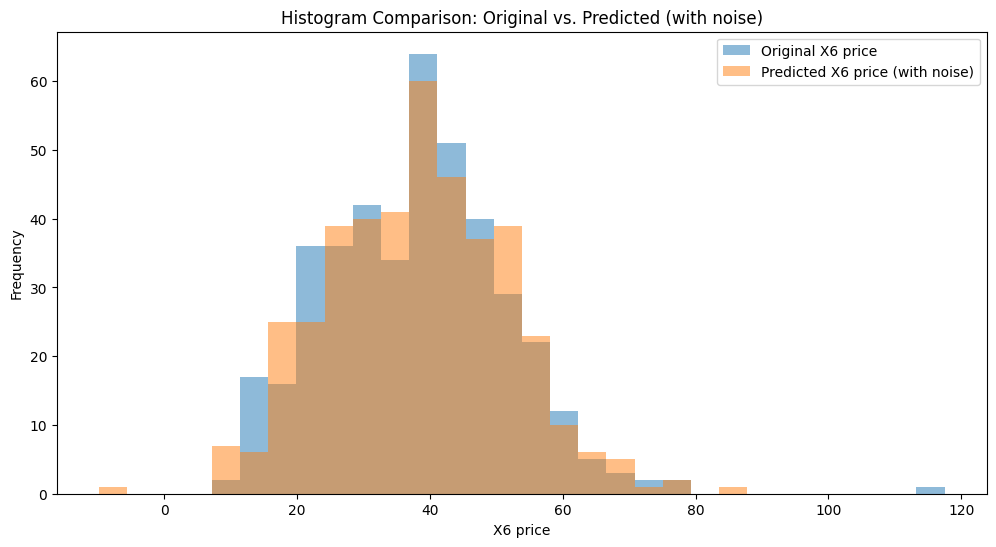

In [225]:
bins = np.histogram_bin_edges(np.concatenate([y, y_pred_bootstrap]), bins=30)
plt.figure(figsize=(12, 6))
plt.hist(y, bins=bins, alpha=0.5, label="Original X6 price")
plt.hist(y_pred_bootstrap, bins=bins, alpha=0.5, label="Predicted X6 price (with noise)")
plt.xlabel("X6 price")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: Original vs. Predicted (with noise)")
plt.legend()
plt.show()

Best amplification factor: 1.131578947368421
Corresponding histogram MSE: 6.848361606566375e-06


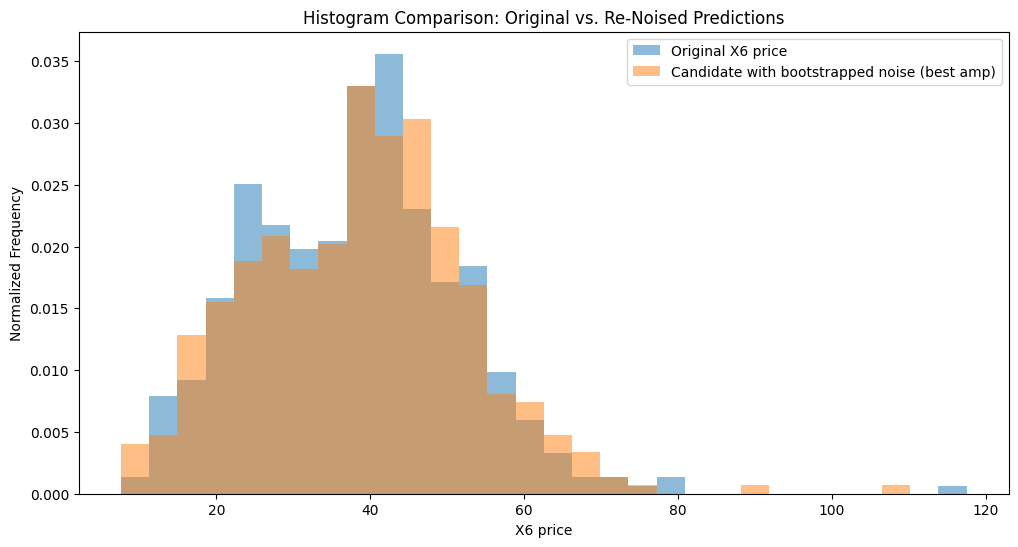

In [318]:
import numpy as np
import matplotlib.pyplot as plt

# Assume these variables are already defined:
# candidate_function    -> your denoised candidate function from symbolic regression
# X                     -> predictor features as a NumPy array
# y                     -> original target data
# residuals             -> y - candidate_function(X) 
# For bootstrapping, we sample from the empirical residuals:

# Get the candidate (denoised) prediction:
y_denoised = candidate_function(X)
residuals = y - y_denoised  # empirical residuals

# Set up a function to perform bootstrapping with an amplification factor,
# compute the re-noised predictions, then return the error between histograms.
def compute_histogram_mse(amplification_factor, bins=30):
    # Fix the seed for reproducibility.
    np.random.seed(42)
    # Sample residuals with replacement using bootstrapping
    bootstrap_noise = np.random.choice(residuals, size=len(y_denoised), replace=True)
    # Reintroduce noise with amplification
    y_pred = y_denoised + amplification_factor * bootstrap_noise
    
    # Compute histograms for both original and predicted data.
    # We'll use density=True so that differences in total count are normalized out.
    hist_original, bin_edges = np.histogram(y, bins=bins, density=True)
    hist_pred, _ = np.histogram(y_pred, bins=bin_edges, density=True)
    
    # Compute Mean Squared Error between the two histograms.
    mse = np.mean((hist_original - hist_pred) ** 2)
    return mse, bin_edges, hist_original, hist_pred, y_pred

# Perform a simple grid search over a range of amplification factors.
amplification_factors = np.linspace(0.5, 2.0, 20)
errors = []

for factor in amplification_factors:
    mse, _, _, _, _ = compute_histogram_mse(factor, bins=30)
    errors.append(mse)

# Find the amplification factor that yields the smallest histogram error.
best_idx = np.argmin(errors)
best_amp = amplification_factors[best_idx]
print("Best amplification factor:", best_amp)
print("Corresponding histogram MSE:", errors[best_idx])

# Use the best amplification factor to generate the final predictions.
mse, bin_edges, hist_original, hist_pred, y_pred_final = compute_histogram_mse(best_amp, bins=30)

# Plot the final histograms for comparison.
plt.figure(figsize=(12, 6))
plt.hist(y, bins=bin_edges, density=True, alpha=0.5, label="Original X6 price")
plt.hist(y_pred_final, bins=bin_edges, density=True, alpha=0.5, label="Candidate with bootstrapped noise (best amp)")
# plt.hist(y_denoised, bins=bin_edges, density=True, alpha=0.5, label="simply denoised")
plt.xlabel("X6 price")
plt.ylabel("Normalized Frequency")
plt.title("Histogram Comparison: Original vs. Re-Noised Predictions")
plt.legend()
plt.show()


In [339]:
# 1) Your denoised prediction & residuals
y_denoised = candidate_function(X)
residuals = y - y_denoised

# 2) Bin edges & indices
n_bins = 32
edges = np.quantile(y_denoised, np.linspace(0, 1, n_bins + 1))
bin_idx = np.digitize(y_denoised, edges[1:-1])  # 0..n_bins-1 guaranteed

# 3) Group residuals by bin
residuals_by_bin = {
    b: residuals[bin_idx == b]
    for b in range(n_bins)
}

# 4) Sample residuals stratified by bin (with a global fallback)
np.random.seed(42)
bootstrap_noise = np.empty_like(y_denoised)
for i in range(len(y_denoised)):
    pool = residuals_by_bin.get(bin_idx[i])
    if pool is None or pool.size == 0:
        pool = residuals
    bootstrap_noise[i] = np.random.choice(pool)

# 5) Final prediction (and optional clipping at zero)
y_pred = y_denoised + bootstrap_noise
y_pred = np.maximum(y_pred, 0)  # if you want no negatives

In [332]:
y_pred = y_denoised + bootstrap_noise

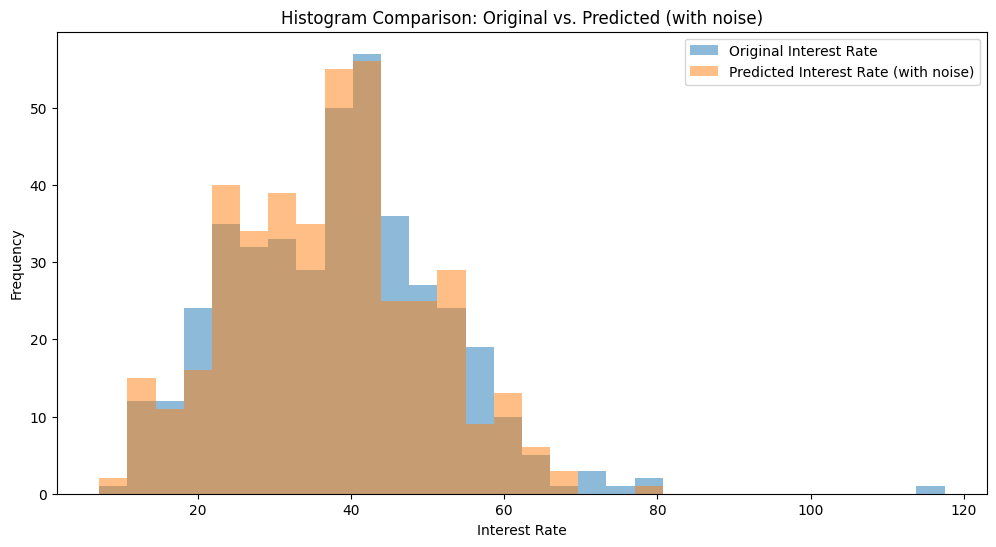

In [340]:
bins = np.histogram_bin_edges(np.concatenate([y, y_pred]), bins=30)
plt.figure(figsize=(12, 6))
plt.hist(y, bins=bins, alpha=0.5, label="Original Interest Rate")
plt.hist(y_pred, bins=bins, alpha=0.5, label="Predicted Interest Rate (with noise)")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: Original vs. Predicted (with noise)")
plt.legend()
plt.show()